1D Polynomial:
Equation: y = 0.6084 * x + 39.3476
R² = 0.7863
RMSE = 26.3435
MAE = 22.3002

2D Polynomial:
Equation: y = -0.0020 * x² + 1.2563 * x + 1.2218
R² = 0.8425
RMSE = 22.6174
MAE = 17.9751

3D Polynomial:
Equation: y = 0.0000 * x³ + -0.0070 * x² + 1.9217 * x + -20.1602
R² = 0.8529
RMSE = 21.8532
MAE = 17.1602

4D Polynomial:
Equation: y = 0.0000 * x⁴ + 0.0000 * x³ + -0.0051 * x² + 1.7788 * x + -17.3525
R² = 0.8530
RMSE = 21.8446
MAE = 17.1450



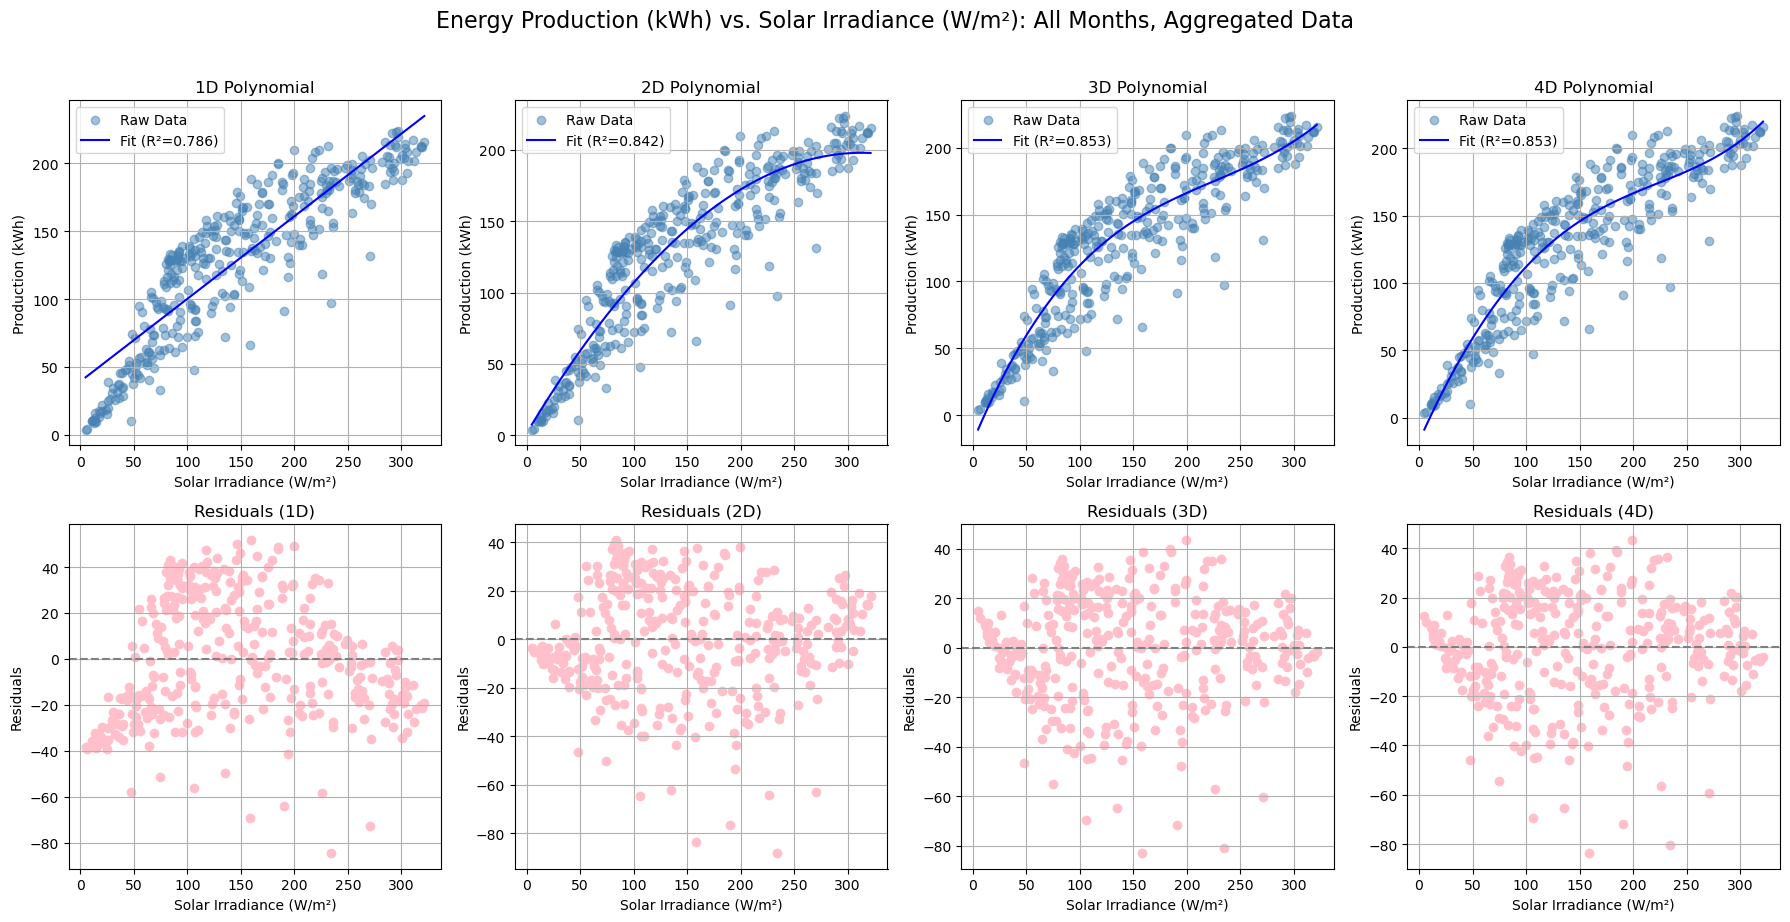

Best model: 4D Polynomial
Best model R²: 0.8530
Note: Beware of overfitting


In [79]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Loading data from file
df_orig = pd.read_csv('Energy_Weather_Input_Data.csv')

# Renaming columns
df_orig.columns = ['TimeStamp', 'Produced(Wh)', 'Consumed(Wh)', 'Temp(F)', 'SolarRadiation(W/m2)']

# Converting timestamp column to datetime format
df_orig['TimeStamp'] = pd.to_datetime(df_orig['TimeStamp'])
df_orig['Month'] = df_orig['TimeStamp'].dt.month # Extracting month from each timestamp
df_orig['Date'] = df_orig['TimeStamp'].dt.date # Extracting day from each timestamp

# Converting energy data from Wh to kWh
df_orig['Produced(kWh)'] = df_orig['Produced(Wh)'] / 1000
df_orig['Consumed(kWh)'] = df_orig['Consumed(Wh)'] / 1000

# -------------------
# AGGREGATED OPTION
# -------------------

# Aggregating data by grouping it daily
df_daily = df_orig.groupby('Date').agg({
    'Temp(F)': 'mean', # average temperature
    'Produced(kWh)': 'sum', # total production
    'Consumed(kWh)': 'sum', # total consumption
    'SolarRadiation(W/m2)': 'mean' # average solar irradiance
}).reset_index()

# Extracting month from aggregated data
df_daily['Month'] = pd.to_datetime(df_daily['Date']).dt.month

# -----------------------------
# AGGREGATED & SMOOTHED OPTION
# -----------------------------

# Creating smoothed consumption/production columns
df_daily['SmoothedConsumed(kWh)'] = df_daily['Consumed(kWh)'].rolling(window=3, center=True).mean()
df_daily['SmoothedProduced(kWh)'] = df_daily['Produced(kWh)'].rolling(window=3, center=True).mean()
df_daily_smooth = df_daily.dropna(subset=['SmoothedConsumed(kWh)', 'SmoothedProduced(kWh)']).copy() # dropping missing rows from edges

# Extracting month from aggregated/smoothed data
df_daily_smooth['Month'] = pd.to_datetime(df_daily_smooth['Date']).dt.month

# ------------------
# COLD/WARM OPTION
# ------------------

# Splitting dataset into cold and warm months
cold_months = [11, 12, 1, 2, 3] 
warm_months = [5, 6, 7, 8, 9]

# Cold/Warm data without aggregation
df_cold_orig = df_orig[df_orig['Month'].isin(cold_months)]
df_warm_orig = df_orig[df_orig['Month'].isin(warm_months)]

# Cold/Warm data with aggregation
df_cold_daily = df_daily[df_daily['Month'].isin(cold_months)]
df_warm_daily = df_daily[df_daily['Month'].isin(warm_months)]

# Cold/Warm data with aggreagaton and smoothing
df_cold_daily_smooth = df_daily_smooth[df_daily_smooth['Month'].isin(cold_months)]
df_warm_daily_smooth = df_daily_smooth[df_daily_smooth['Month'].isin(warm_months)]

# Dataframe options:
# - Full, original dataset: df_orig
# - Split, original dataset: df_cold_orig, df_warm_orig
# - Full, truncated dataset: df_daily
# - Split, truncated dataset: df_cold_daily, df_warm_daily
# - Full, truncated and smoothed dataset: df_daily_smooth
# - Split, truncated and smoothed dataset: df_cold_daily_smooth, df_warm_daily_smooth

# -----------------------------
# USER ASSIGNS TYPE OF DATASET
# -----------------------------

df_choice = df_daily

# Setting x and y
x_data = df_choice['SolarRadiation(W/m2)'].values # either 'Temp(F)' or 'SolarRadiation(W/m2)'
y_data = df_choice['Produced(kWh)'].values # either 'Consumed(kWh)' or 'Produced(kWh)'

# Assigning the correct labels for the plot depending on the choice of dataset type
if (df_choice is df_orig):
    data_spec_label = "All Months, Original Data"
elif (df_choice is df_daily):
    data_spec_label = "All Months, Aggregated Data"
elif (df_choice is df_cold_orig):
    data_spec_label = "Cold Months, Original Data"
elif (df_choice is df_warm_orig):
    data_spec_label = "Warm Months, Original Data"
elif (df_choice is df_cold_daily):
    data_spec_label = "Cold Months, Aggregated Data"
elif (df_choice is df_warm_daily):
    data_spec_label = "Warm Months, Aggregated Data"
elif (df_choice is df_daily_smooth):
    data_spec_label = "All Months, Aggregated and Smoothed Data"

# Assigning correct labels for title, x and y axis depending on choice of x and y data
if (x_data is df_choice['Temp(F)'].values):
    plot_title = "Energy Consumption (kWh) vs. Temperature (°F)"
    x_label = "Temperature (°F)"
    y_label = "Consumption (kWh)"

elif (x_data is df_choice['SolarRadiation(W/m2)'].values):
    plot_title = "Energy Production (kWh) vs. Solar Irradiance (W/m²)"
    x_label = "Solar Irradiance (W/m²)"
    y_label = "Production (kWh)"


# -------------------------------------------------------------------------------------


# --------------------------
# FITTING POLYNOMIAL MODELS
# --------------------------

# Polynomial degrees: linear, quadratic, cubic, quartic
degrees = [1, 2, 3, 4]

# Empty dictionary to store results
results = {}

# Initializing best model info
best_r2 = 0
best_model_name = None
best_model_params = None
best_model_residuals = None
best_model_metrics = None

# Generating a figure for plotting
fig, axs = plt.subplots(2, len(degrees), figsize=(18,9))

# Iterating through each polynomial degree
for i, deg in enumerate(degrees):
    
    coeffs = np.polyfit(x_data, y_data, deg) # fitting data and solving for coefficients
    y_pred = np.polyval(coeffs, x_data) # calculating predicted values
    residuals = y_data - y_pred # calculating residuals
    r2 = r2_score(y_data, y_pred) # calculating coefficient of determination
    rmse = np.sqrt(mean_squared_error(y_data, y_pred)) # calculating root mean squared error
    mae = mean_absolute_error(y_data, y_pred) # calculating mean absolute error
    results[f'{deg}D'] = (coeffs, residuals, r2, rmse, mae) # storing results in dictionary

    # Writing fitted equations
    if deg == 1:
        eqn = f"y = {coeffs[0]:.4f} * x + {coeffs[1]:.4f}"
    elif deg == 2:
        eqn = f"y = {coeffs[0]:.4f} * x² + {coeffs[1]:.4f} * x + {coeffs[2]:.4f}"
    elif deg == 3:
        eqn = f"y = {coeffs[0]:.4f} * x³ + {coeffs[1]:.4f} * x² + {coeffs[2]:.4f} * x + {coeffs[3]:.4f}"
    elif deg == 4:
        eqn = f"y = {coeffs[0]:.4f} * x⁴ + {coeffs[1]:.4f} * x³ + {coeffs[2]:.4f} * x² + {coeffs[3]:.4f} * x + {coeffs[4]:.4f}"

    # Printing results
    print(f"{deg}D Polynomial:")
    print(f"Equation: {eqn}")
    print(f"R² = {r2:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"MAE = {mae:.4f}\n")

    # Identifying best fit model
    if r2 > best_r2:
        best_r2 = r2
        best_model_deg = deg
        best_model_coeffs = coeffs
        best_model_metrics = (residuals, rmse, mae)

    # Plotting
    x_fit = np.linspace(x_data.min(), x_data.max(), 100) # generating smooth curve for plotting
    y_fit = np.polyval(coeffs, x_fit)
    # Polynomial Fits
    axs[0, i].scatter(x_data, y_data, color='steelblue', alpha=0.5, label='Raw Data') # raw data
    axs[0, i].plot(x_fit, y_fit, 'b-', label=f'Fit (R²={r2:.3f})') # fitted data
    axs[0, i].set_title(f'{deg}D Polynomial')
    axs[0, i].set_xlabel(x_label)
    axs[0, i].set_ylabel(y_label)
    axs[0, i].legend()
    axs[0, i].grid(True)
    # Residuals
    axs[1, i].scatter(x_data, residuals, color='pink')
    axs[1, i].axhline(0, color='gray', linestyle='--')
    axs[1, i].set_title(f'Residuals ({deg}D)')
    axs[1, i].set_xlabel(x_label)
    axs[1, i].set_ylabel('Residuals')
    axs[1, i].grid(True)

plt.suptitle(f'{plot_title}: {data_spec_label}', fontsize=16, y=1.02) # specifying type of data
plt.tight_layout()
plt.show()

# Printing best model results
print(f"Best model: {best_model_deg}D Polynomial")
print(f"Best model R²: {best_r2:.4f}")
print("Note: Beware of overfitting")
